# 태양광
***
### 3년(Day 0 ~ Day 1094) 동안의 기상 데이터, 발전량(TARGET) 데이터

### test는 2년동안의 기상데이터, 발전량(TARGET) 데이터

### 각 파일의 7일 동안의 데이터 전체 혹은 일부 활용하여 향후 2일 동안의 30분 간격 발전량 예측
****
- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)

In [287]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg as qreg
import statsmodels.formula.api as smf

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [288]:
train = pd.read_csv('C:/Users/kcisa/Downloads/data/train/train.csv')

In [289]:
for i in range(81) :
    globals() [f'test_{i}'] = pd.read_csv(f'C:/Users/kcisa/Downloads/data/test/{i}.csv')

In [290]:
### 각 데이터를 하나의 데이터로 통합
test = pd.DataFrame()
for i in range(81):
    test = pd.concat([test, globals()[f'test_{i}']], axis = 0, ignore_index = True)

In [346]:
submission = pd.read_csv('C:/Users/kcisa/Downloads/data/sample_submission.csv')

In [292]:
train['new_day'] = train.Day % 9

In [293]:
train.skew()

Day        0.000000
Hour       0.000000
Minute     0.000000
DHI        2.148660
DNI        1.119875
WS         1.199683
RH        -0.007108
T          0.185200
TARGET     1.326131
new_day    0.004294
dtype: float64

In [294]:
np.log1p(train).skew()

Day       -1.861071e+00
Hour      -1.173855e+00
Minute     6.102021e-13
DHI        2.351868e-01
DNI        4.578739e-01
WS         4.267993e-02
RH        -8.597876e-01
T                   NaN
TARGET     4.015453e-01
new_day   -8.344415e-01
dtype: float64

In [295]:
train['DNI'] = np.log1p(train['DNI'])
train['DHI'] = np.log1p(train['DHI'])
train['WS'] = np.log1p(train['WS'])

In [296]:
test['DNI'] = np.log1p(test['DNI'])
test['DHI'] = np.log1p(test['DHI'])
test['WS'] = np.log1p(test['WS'])

In [297]:
train.Minute = train.Minute.map({30 : 1, 0: 0})
test.Minute = test.Minute.map({30 : 1, 0: 0})

In [298]:
train['hour_mean'] = train.Hour.map(train.groupby('Hour').TARGET.mean())
test['hour_mean'] = test.Hour.map(test.groupby('Hour').TARGET.mean())

In [299]:
train_after_2 = train.loc[train.Day <= 1092]

In [300]:
train_after_2['TARGET2'] = list(train.loc[train.Day >= 2].TARGET)

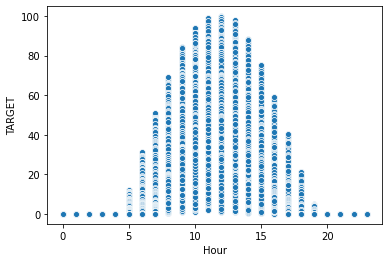

In [301]:
sns.scatterplot(train_after_2.Hour, train_after_2.TARGET)

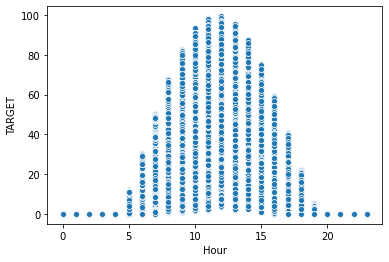

In [302]:
sns.scatterplot(test.Hour, test.TARGET)

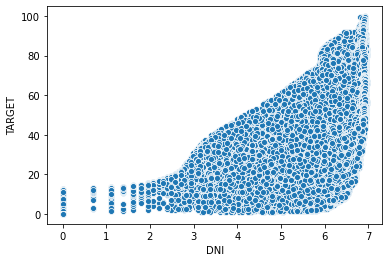

In [303]:
sns.scatterplot(train_after_2.DNI, train_after_2.TARGET)

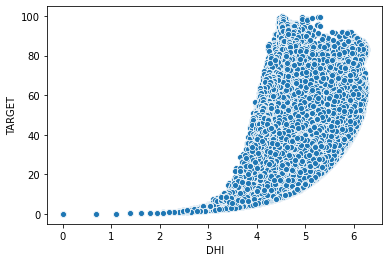

In [304]:
sns.scatterplot(train_after_2.DHI, train_after_2.TARGET)

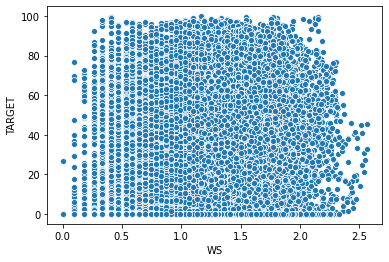

In [305]:
sns.scatterplot(train_after_2.WS, train_after_2.TARGET)

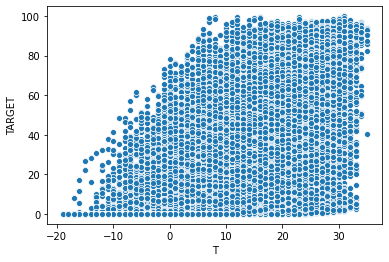

In [306]:
sns.scatterplot(train_after_2['T'], train_after_2.TARGET)

In [307]:
train_after_2.drop(['new_day','Day'], axis =1 ,inplace = True)

In [308]:
target1 = test.query('Day in [0, 1]').drop(['Day'], axis =1)
target2 = test.query('Day in [1, 2]').drop(['Day'], axis =1)
target3 = test.query('Day in [2, 3]').drop(['Day'], axis =1)
target4 = test.query('Day in [3, 4]').drop(['Day'], axis =1)

target_list = [target1, target2, target3, target4]

In [309]:
actual1 = test.query('Day in [2,3]').TARGET
actual2 = test.query('Day in [3,4]').TARGET
actual3 = test.query('Day in [4,5]').TARGET
actual4 = test.query('Day in [5,6]').TARGET

actual_list = [actual1, actual2, actual3, actual4]

In [311]:
X = train_after_2.drop('TARGET2', axis = 1)
y = train_after_2.TARGET2

In [359]:
target = test.query('Day in [5,6]').drop('Day', axis = 1)

In [313]:
def pb_loss(true, pred, q) :
    
    L_list = []
    
    for i in range(len(true)) :
        
        if true.iloc[i] >= pred[i] :
            L = true.iloc[i] - pred[i]
            L *= q
            
        else :
            L1 = pred[i] - true.iloc[i]
            L2 = 1 - q
            L = L1 * L2
            
        L_list.append(L)
        
    return np.mean(L_list)

In [356]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
        
        gbm = GradientBoostingRegressor(random_state = 1216, loss = 'quantile', alpha = qt)
        gbm.fit(X, y)

        pred = gbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)
        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

0.1 quantile pinball_loss는 1.4683716949637835
0.2 quantile pinball_loss는 1.906389636816968
0.3 quantile pinball_loss는 2.1883604349063535
0.4 quantile pinball_loss는 2.3598069576420038
0.5 quantile pinball_loss는 2.440611855745557
0.6 quantile pinball_loss는 2.4472998653000944
0.7 quantile pinball_loss는 2.4010407839210295
0.8 quantile pinball_loss는 2.304521381347873
0.9 quantile pinball_loss는 2.165280908497653
0.1 quantile pinball_loss는 1.470190056367998
0.2 quantile pinball_loss는 1.944325182720808
0.3 quantile pinball_loss는 2.2607070492181607
0.4 quantile pinball_loss는 2.4533127816327873
0.5 quantile pinball_loss는 2.553581170426906
0.6 quantile pinball_loss는 2.5711438658011034
0.7 quantile pinball_loss는 2.5250810835893254
0.8 quantile pinball_loss는 2.423301605595849
0.9 quantile pinball_loss는 2.27286007426924
0.1 quantile pinball_loss는 1.5661145819504854
0.2 quantile pinball_loss는 2.1001021779651197
0.3 quantile pinball_loss는 2.450232936077933
0.4 quantile pinball_loss는 2.660115897017466


In [360]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    gbm = GradientBoostingRegressor(random_state = 1216, loss = 'quantile', alpha = q)
    gbm.fit(X, y)

    gbm_pred = gbm.predict(target)
    submission[f'q_{q}'] = gbm_pred
gbm_submission = submission.copy()

In [379]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :

        lgbm = LGBMRegressor(random_state = 1216, objective = 'quantile', metric = 'quantile', alpha = qt)
        lgbm.fit(X, y)

        pred = lgbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)

        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4506250413367714
0.2 quantile pinball_loss는 1.910890211444802
0.3 quantile pinball_loss는 2.202513808339355
0.4 quantile pinball_loss는 2.3766495563581818
0.5 quantile pinball_loss는 2.457543885378926
0.6 quantile pinball_loss는 2.4547659726319067
0.7 quantile pinball_loss는 2.397312822225255
0.8 quantile pinball_loss는 2.291688703699516
0.9 quantile pinball_loss는 2.1479188638132074
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4778540289800188
0.2 quantile pinball_loss는 1.969737796764635
0.3 quantile pinball_loss는 2.297238415461385
0.4 quantile pinball_loss는 2.48327045529642
0.5 quantile pinball_loss는 2.5802644490859947
0.6 quantile pinball_loss는 2.589975881972404
0.7 quantile pinball_loss는 2.5341456098181583
0.8 quantile pinball_loss는 2.4236872582347244
0.9 quantile pinball_loss는 2.2650745709796016
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5877775858269916
0.2 quantile pinball_loss는 2.0989559274510676
0.3 quantile pinball_los

In [364]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    lgbm = LGBMRegressor(random_state = 1216, objective = 'quantile', metric = 'quantile', alpha = q)
    lgbm.fit(X, y)

    lgbm_pred = lgbm.predict(data[0])
    submission[f'q_{q}'] = lgbm_pred
lgbm_submission = submission.copy()

In [366]:
lgbm_submission.iloc[:, 1:] *= .47
gbm_submission.iloc[:, 1:] *= .53

In [367]:
submission.iloc[:, 1:] = lgbm_submission.iloc[:, 1:] + gbm_submission.iloc[:, 1:]

In [376]:
submission.iloc[:, 1:] = submission.iloc[:, 1:].applymap(lambda x : 0 if x < 0 else x)

In [377]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.763157,11.488957,14.935893,17.343788,19.235465,20.555571,21.710883,22.940743,24.608230
std,9.539534,15.584794,19.810747,22.738868,25.006016,26.543465,27.745210,28.898845,30.018123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000237,0.000621,0.001095,0.002088
50%,0.285094,0.567668,0.930214,1.272373,1.954627,2.148332,2.559797,2.765919,5.129883
75%,13.159597,23.231106,30.347753,34.816719,38.606948,41.177708,43.419085,46.195227,49.724886
max,48.083922,78.992927,79.717472,82.624782,86.633166,88.776655,92.886479,94.753820,96.552402


In [378]:
submission.to_csv('3rd.csv', index = False)